In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from __future__ import print_function

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Simulated data

In [3]:
true_rate = 4.345
np.random.seed(42)
N_obs = float(np.random.poisson(true_rate))
print("N_obs = {0:.0f}".format(N_obs))

N_obs = 5


## "Exact" posterior using MCMC

In [4]:
prior_range = np.log(N_obs) + np.array([-3, 1.5])

def lnprior(ln_mu):
    if not prior_range[0] < float(ln_mu) < prior_range[1]:
        return -np.inf
    return 0.0

def lnprob(ln_mu):
    ln_mu = float(ln_mu)
    return lnprior(ln_mu) + N_obs * ln_mu - np.exp(ln_mu)

In [5]:
def mh(log_p_func, theta0, niter, sigma=0.1):
    ndim = len(theta0)
    theta = np.array(theta0)
    chain = np.empty((niter, ndim))
    lp = log_p_func(theta0)
    acc = 0
    for i in range(niter):
        q = np.array(theta)
        ind = np.random.randint(ndim)
        q[ind] += sigma * np.random.randn()
        lq = log_p_func(q)

        u = np.log(np.random.rand())
        if u < lq - lp:
            theta = q
            lp = lq
            acc += 1
        
        chain[i] = theta

    return chain, acc / niter

In [6]:
chain_true, acc = mh(lnprob, np.log([N_obs]), 100000)
acc

0.93061

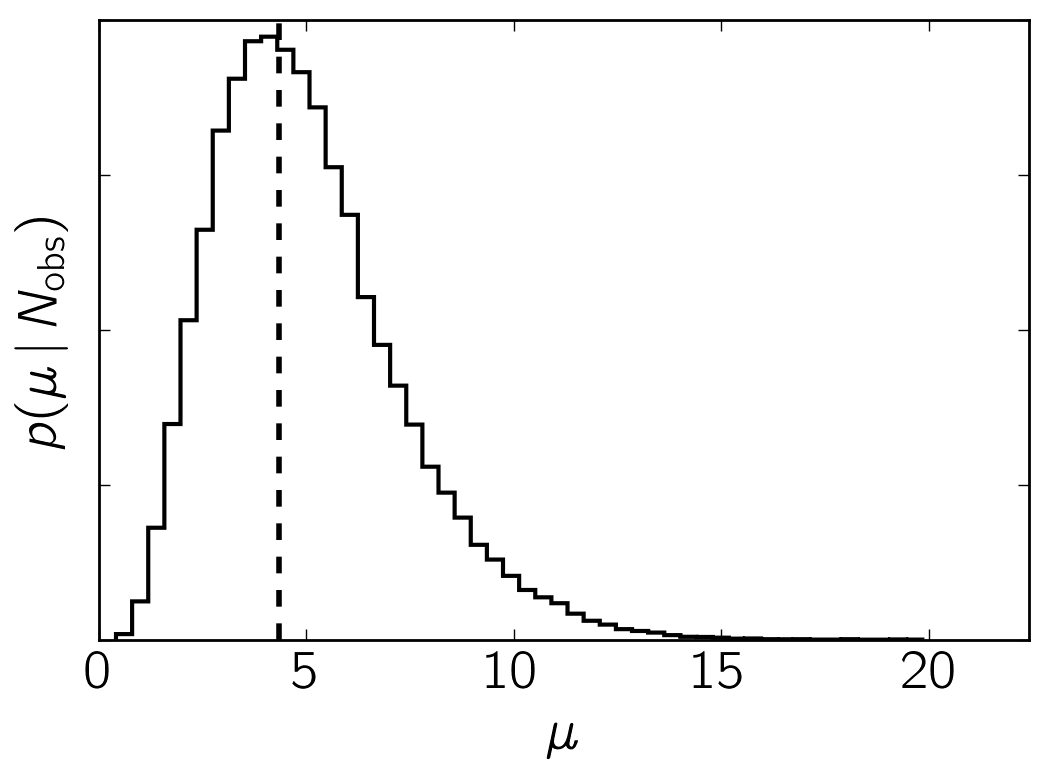

In [7]:
plt.hist(np.exp(chain_true), 50, histtype="step", color="k", lw=1.5, normed=True)
plt.gca().set_yticklabels([])
plt.xlabel("$\mu$")
plt.ylabel("$p(\mu\,|\,N_\mathrm{obs})$")
plt.xlim(0, np.exp(prior_range[1]))
plt.gca().axvline(true_rate, lw=2, color="k", ls="dashed");

## Stupid method

In [8]:
def simulator(ln_mu):
    return np.random.poisson(np.exp(ln_mu))

def fake_ln_prob_1(ln_mu):
    sim = simulator(float(ln_mu))
    r = sim / N_obs
    return lnprior(ln_mu) + N_obs * (1. - r + np.log(r))
    # return lnprior(ln_mu) + N_obs * np.log(sim) - sim

def fake_ln_prob_2(ln_mu):
    sim = simulator(float(ln_mu))
    return lnprior(ln_mu) - 0.5 * (N_obs - sim)**2 / N_obs

In [9]:
chain_stupid_1, acc = mh(fake_ln_prob_1, np.log([N_obs]), 100000)
acc

/Users/dfm/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log


0.58926

In [10]:
chain_stupid_2, acc = mh(fake_ln_prob_2, np.log([N_obs]), 100000)
acc

0.66626

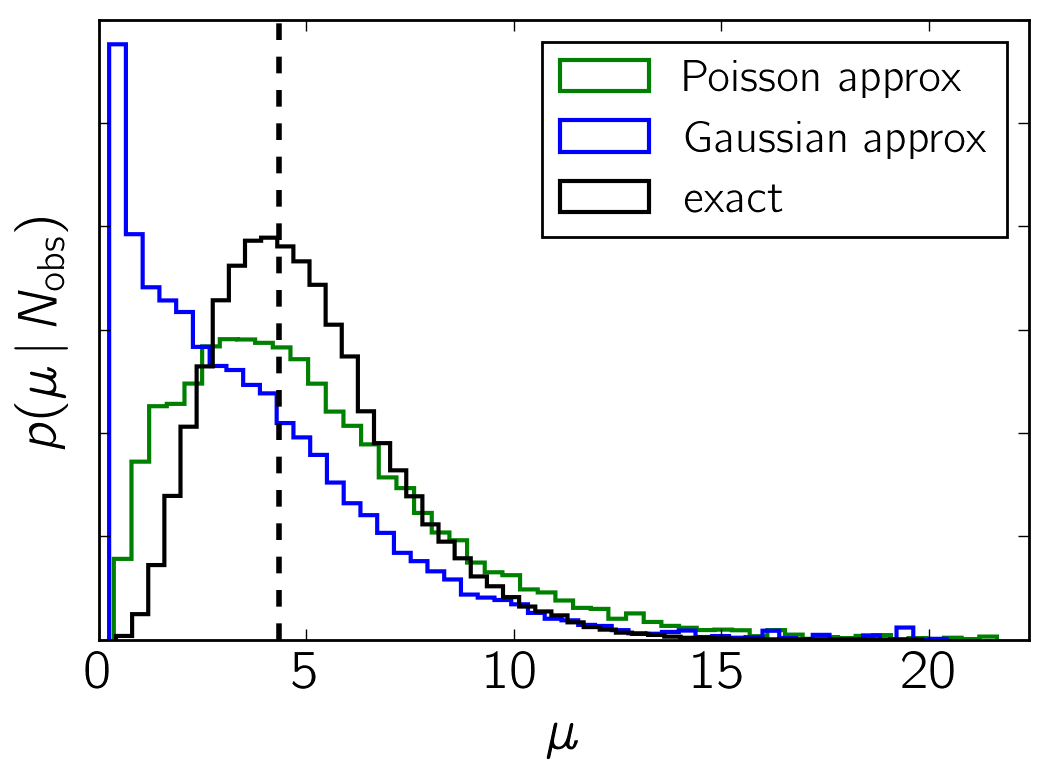

In [11]:
plt.hist(np.exp(chain_stupid_1), 50, histtype="step", color="g", lw=1.5, normed=True, label="Poisson approx")
plt.hist(np.exp(chain_stupid_2), 50, histtype="step", color="b", lw=1.5, normed=True, label="Gaussian approx")
plt.hist(np.exp(chain_true), 50, histtype="step", color="k", lw=1.5, normed=True, label="exact")
plt.gca().set_yticklabels([])
plt.xlabel("$\mu$")
plt.ylabel("$p(\mu\,|\,N_\mathrm{obs})$")
plt.xlim(0, np.exp(prior_range[1]))
plt.gca().axvline(true_rate, lw=2, color="k", ls="dashed")
plt.legend(fontsize=16);

/Users/dfm/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


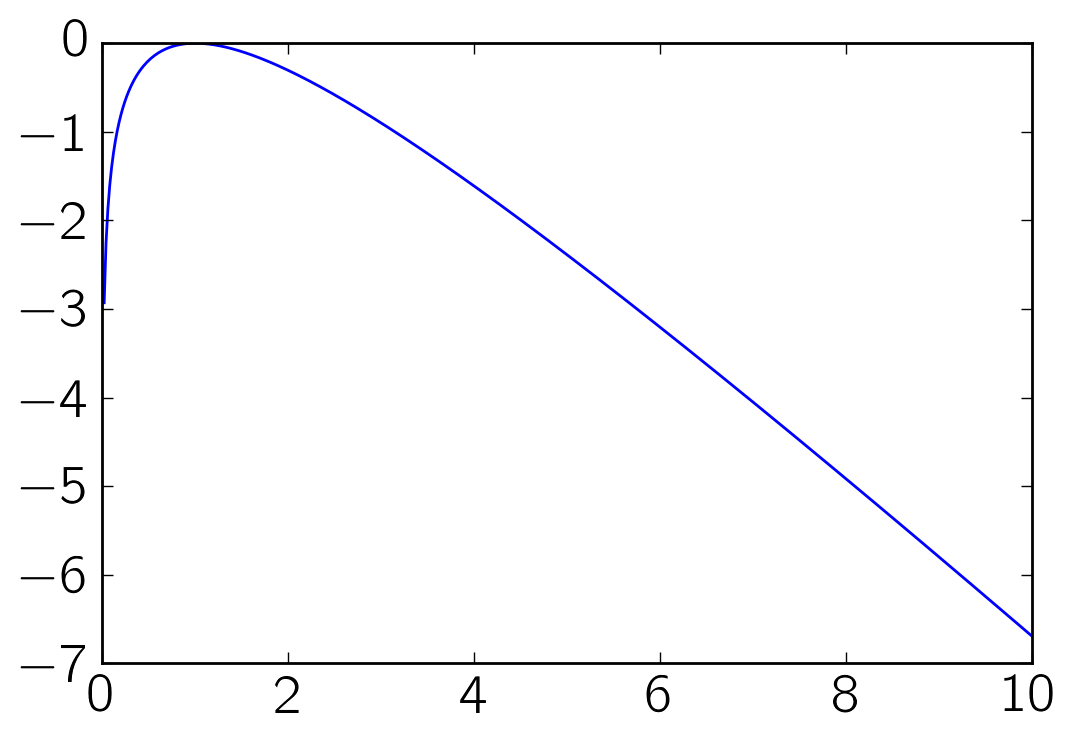

In [12]:
r = np.linspace(0, 10, 500)
plt.plot(r, 1. - r + np.log(r))

## ABC

In [13]:
def abc_simulator():
    ln_mu = np.random.uniform(*prior_range)
    return ln_mu, np.random.poisson(np.exp(ln_mu))

def run_abc(n_min, eps):
    chain = []
    ntot = 0
    while len(chain) < n_min:
        samp, sim = abc_simulator()
        r = sim / N_obs
        dist = r - 1.0 - np.log(r) # (sim - N_obs) ** 2 / N_obs
        if dist < eps:
            chain.append((dist, samp))
        ntot += 1
    print(ntot)
    return np.array(chain)

In [14]:
chain_abc = run_abc(20000, 0.01)

/Users/dfm/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log


451247


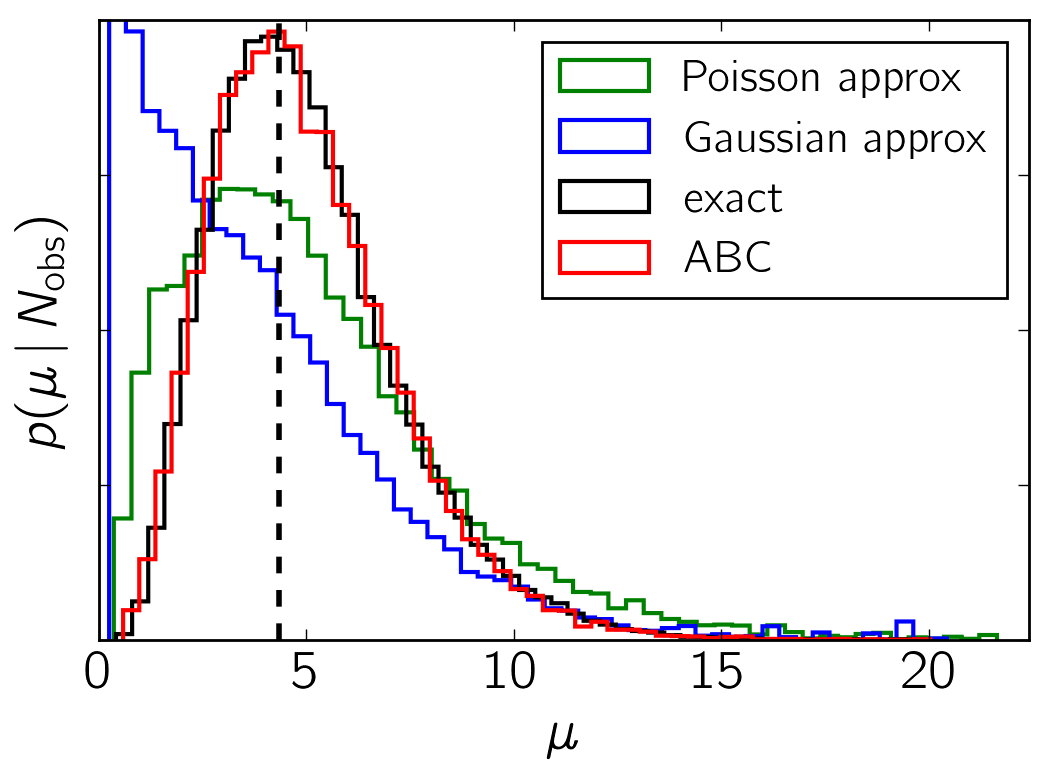

In [15]:
plt.hist(np.exp(chain_stupid_1), 50, histtype="step", color="g", lw=1.5, normed=True, label="Poisson approx")
plt.hist(np.exp(chain_stupid_2), 50, histtype="step", color="b", lw=1.5, normed=True, label="Gaussian approx")
plt.hist(np.exp(chain_true), 50, histtype="step", color="k", lw=1.5, normed=True, label="exact")
plt.hist(np.exp(chain_abc[:, 1]), 50, histtype="step", color="r", lw=1.5, normed=True, label="ABC")
plt.gca().set_yticklabels([])
plt.xlabel("$\mu$")
plt.ylabel("$p(\mu\,|\,N_\mathrm{obs})$")
plt.xlim(0, np.exp(prior_range[1]))
plt.gca().axvline(true_rate, lw=2, color="k", ls="dashed")
plt.legend(fontsize=16);

In [17]:
print(np.percentile(np.exp(chain_stupid_1), [16, 50, 84]))
print(np.percentile(np.exp(chain_stupid_2), [16, 50, 84]))
print(np.percentile(np.exp(chain_abc[:, 1]), [16, 50, 84]))
print(np.percentile(np.exp(chain_true), [16, 50, 84]))

[ 2.15512124  4.55994543  8.01365495]
[ 0.86194344  3.03194193  6.4482528 ]
[ 2.83527337  4.66971887  7.13369306]
[ 2.88388791  4.704459    7.17179164]
